# Impact of waves on Langmuir turbulence and mixed layer depths

This notebook shows a comparison between 5 experiments all using MOM–CICE–WW3:
- `IC4M8-MCW-100km_jra_ryf_ePBL_additive`: ePBL with `WAVE_METHOD="SURFACE_BANDS"`, `EPBL_LANGMUIR_SCHEME="ADDITIVE"`, and `LMPENABLED=False` (see config [here](https://github.com/NoahDay/access-om3-configs/tree/noah-IC4M8-MCW-100km_jra_ryf_ePBL))
- `IC4M8-MCW-100km_jra_ryf_ePBL_none`: ePBL with `WAVE_METHOD="SURFACE_BANDS"`, `EPBL_LANGMUIR_SCHEME="NONE"`, and `LMPENABLED=False`
- `IC4M8-MCW-100km_jra_ryf_ePBL_rescale`: ePBL with `WAVE_METHOD="SURFACE_BANDS"`, `EPBL_LANGMUIR_SCHEME="RESCALE"`, and `LMPENABLED=False`
- `IC4M8-MCW-100km_jra_ryf_KPP`: KPP with `WAVE_METHOD="EFACTOR"` and `LMPENABLED=True` (see config [here](https://github.com/NoahDay/access-om3-configs/tree/noah-IC4M8-MCW-100km_jra_ryf_KPP))
<!-- - `IC4M8-MCW-100km_jra_ryf`: ePBL but Langmuir turbulence is not enhanced by WW3 (`USE_WAVES=False`), similar to MOM–CICE configurations (see config [here](https://github.com/NoahDay/access-om3-configs/tree/noah-IC4M8-MCW-100km_jra_ryf)) -->

In [1]:
#This cell must be in all notebooks!
#It allows us to run all the notebooks at once, this cell has a tag "parameters" which allows us to pass in 
# arguments externally using papermill (see mkfigs.sh for details)

### USER EDIT start
kpp_file = "/scratch/tm70/ek4684/access-om3/archive/771-MCW_100km_jra_ryf_IC4_KPP/experiment_datastore.json"
epbl_file_additive = "/scratch/ps29/nd0349/access-om3/archive/IC4M8-MCW-100km_jra_ryf_ePBL/experiment_datastore.json"
epbl_file_rescale = "/scratch/ps29/nd0349/access-om3/archive/IC4M8-MCW-100km_jra_ryf_ePBL_RESCALE/experiment_datastore.json"
epbl_file_none = "/scratch/ps29/nd0349/access-om3/archive/IC4M8-MCW-100km_jra_ryf_ePBL_NONE/experiment_datastore.json"

dpi=300
### USER EDIT stop

import os
from matplotlib import rcParams
%matplotlib inline
rcParams["figure.dpi"]= dpi

plotfolder=f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3-paper-figs/"
os.makedirs(plotfolder, exist_ok=True)

 # a similar cell under this means it's being run in batch
print("KPP datastore path: ", kpp_file)
print("ePBL-additive datastore path: ", epbl_file_additive)
print("ePBL-rescale datastore path: ", epbl_file_rescale)
print("ePBL-none datastore path: ", epbl_file_none)
print("Plot folder path: ", plotfolder)

KPP datastore path:  /scratch/tm70/ek4684/access-om3/archive/771-MCW_100km_jra_ryf_IC4_KPP/experiment_datastore.json
ePBL-additive datastore path:  /scratch/ps29/nd0349/access-om3/archive/IC4M8-MCW-100km_jra_ryf_ePBL/experiment_datastore.json
ePBL-rescale datastore path:  /scratch/ps29/nd0349/access-om3/archive/IC4M8-MCW-100km_jra_ryf_ePBL_RESCALE/experiment_datastore.json
ePBL-none datastore path:  /scratch/ps29/nd0349/access-om3/archive/IC4M8-MCW-100km_jra_ryf_ePBL_NONE/experiment_datastore.json
Plot folder path:  /g/data/ps29/nd0349/access-om3-paper-figs/


## Load in libraries

In [2]:
import xarray as xr
import cf_xarray as cfxr
import cf_xarray.units
import pint_xarray
from pint import application_registry as ureg
import intake
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib.colors import LogNorm
from distributed import Client
import cftime
import os
import matplotlib.pyplot as plt
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
from textwrap import wrap
import cmocean.cm as cmo
xr.set_options(keep_attrs=True);  # cf_xarray works best when xarray keeps attributes by default

import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines
import string
import xesmf

In [3]:
client = Client(threads_per_worker=1)
client

<Client: 'tcp://127.0.0.1:38515' processes=4 threads=4, memory=18.00 GiB>

In [4]:
print(client.dashboard_link)

/proxy/8787/status


## Define plotting functions

In [5]:
blue_marble = plt.imread('/g/data/ik11/grids/BlueMarble.tiff')
blue_marble_extent = (-180, 180, -90, 90)

In [6]:
def get_proj(hemisphere):
    if hemisphere.lower().startswith('s'):
        # South pole
        projection = ccrs.SouthPolarStereo(central_longitude=0)
        extent = [-180, 180, -90, -40]
    elif hemisphere.lower().startswith('n'):
        # North pole
        projection = ccrs.Stereographic(
            central_latitude=90.0,
            central_longitude=-45.0,
            true_scale_latitude=60.0,
            globe=ccrs.Globe(semimajor_axis=6378273.0, semiminor_axis=6356889.448910593)
        )
        extent = [0, 360, 40, 90]
    elif hemisphere.lower().startswith('g'):
        # Global
        projection = ccrs.Robinson(central_longitude=-100)
        extent = [-180, 180, -90, 90]
    else:
        raise ValueError("hemisphere must be 'north' or 'south' or 'global'")
    return projection, extent

def make_fig(number_panels=1, hemisphere='south'):
   
    projection, extent = get_proj(hemisphere)

    if hemisphere.lower().startswith('g'):
        nrows = number_panels
        ncols = 1
        figwidth = 4
        figheight = 3 * number_panels
    else:
        nrows = 1
        ncols = number_panels
        figwidth = 4 * number_panels
        figheight = 4
        
    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        subplot_kw={'projection': projection},
        figsize=(figwidth, figheight),
        gridspec_kw={'wspace': 0.25, 'hspace': 0.15}
    )

    
    for ax in axes:
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        if not hemisphere.lower().startswith('g'):
            # Make a circle plot
            theta = np.linspace(0, 2*np.pi, 100)
            center, radius = [0.5, 0.5], 0.5
            verts = np.vstack([np.sin(theta), np.cos(theta)]).T
            circle = mpath.Path(verts * radius + center)
            ax.set_boundary(circle, transform=ax.transAxes)
        ax.set_title("NO DATA")

    return fig, axes

def plot(dat,  dat_ice=None, ax=None, title=None, hemisphere='south', label="", vmin=None, vmax=None, **kwargs):
    if title is None:
    #     # title = dat.attrs['long_name']
        title = "NO DATA"
        
    if ax == None:
        fig, ax = make_fig(hemisphere='south')
    
    dat.plot.contourf(
        ax=ax,
        x="lon", 
        y="lat", 
        vmin=vmin,
        vmax=vmax,
        transform=ccrs.PlateCarree(),
        cbar_kwargs={"label": label, # "\n".join(wrap(f"{dat.attrs['long_name']} [{dat.attrs['units']}]", 45))
                     "fraction": 0.03, "aspect": 15, "shrink": 0.7},
        **kwargs
    )
    ax.set_title(title)
    ax.imshow(
        blue_marble, extent=blue_marble_extent, transform=ccrs.PlateCarree(), origin="upper"
    )
    if dat_ice is not None:
        add_ice_contours(ax, dat_ice, hemisphere)

def add_ice_contours(ax, dat_ice, hemisphere):

    projection, extent = get_proj(hemisphere)
        
    transformed_coor=projection.transform_points(ccrs.PlateCarree(),dat_ice['lon'].values,dat_ice['lat'].values)
    x_ster,y_ster=transformed_coor[:,:,0],transformed_coor[:,:,1]
    use_transformed_coordinates_directly = True
    
    if use_transformed_coordinates_directly:
        cs = ax.contour(x_ster,y_ster,dat_ice['aice_m'],levels=[1e-12, 0.15, 0.8],linestyles=[":", "-", "--"],colors="magenta",linewidths=0.5)
    else:
        cs = ax.contour(dat_ice['lon'],dat_ice['lat'],dat_ice['aice_m'],levels=[1e-12, 0.15, 0.8],transform=ccrs.PlateCarree(),
                    linestyles=[":", "-", "--"],colors="magenta",linewidths=0.5)
                
    return cs

## Import data

### Open the intake-esm datastore

In [7]:
COLUMNS_WITH_ITERABLES = [
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
]


datastore_kpp = intake.open_esm_datastore(
    kpp_file,
    columns_with_iterables=COLUMNS_WITH_ITERABLES
)

datastore_epbl = intake.open_esm_datastore(
    epbl_file_additive,
    columns_with_iterables=COLUMNS_WITH_ITERABLES
)

datastore_epbl_rescale = intake.open_esm_datastore(
    epbl_file_rescale,
    columns_with_iterables=COLUMNS_WITH_ITERABLES
)

datastore_epbl_none = intake.open_esm_datastore(
    epbl_file_none,
    columns_with_iterables=COLUMNS_WITH_ITERABLES
)

### What ocean variables are available at monthly frequency?

In [8]:
def available_variables(datastore):
    """Return a pandas dataframe summarising the variables in a datastore"""
    variable_columns = [col for col in datastore.df.columns if "variable" in col]
    return (
        datastore.df[variable_columns]
        .explode(variable_columns)
        .drop_duplicates()
        .set_index("variable")
        .sort_index()
    )

In [9]:
datastore_filtered = datastore_epbl.search(realm="seaIce")

available_variables(datastore_filtered)

variable_long_name  \
variable                                                       
ANGLE          angle grid makes with latitude line on U grid   
ANGLET         angle grid makes with latitude line on T grid   
ELAT                                  E grid center latitude   
ELON                                 E grid center longitude   
HTE                                T cell width on East side   
...                                                      ...   
vort_m                               strain rate (vorticity)   
vvel                                        ice velocity (y)   
vvel_m                                      ice velocity (y)   
wave_sig_ht       significant height of wind and swell waves   
wave_sig_ht_m     significant height of wind and swell waves   

              variable_standard_name variable_cell_methods variable_units  
variable                                                                   
ANGLE                                                             radians  
ANGLET                                                            radians  
ELAT                                                        degrees_north  
ELON                                                         degrees_east  
HTE                                                                     m  
...                              ...                   ...            ...  
vort_m                                          time: mean          %/day  
vvel                                            time: mean            m/s  
vvel_m                                          time: mean            m/s  
wave_sig_ht                                     time: mean              m  
wave_sig_ht_m                                   time: mean              m  

[148 rows x 4 columns]

### Load monthly MLD (`mlotst`), SST (`tos`), and sea ice concentration (`aice_m`)

In [10]:
def load_coords(datastore):
    coords = (
        datastore.search(variable=["geolat", "geolon", "areacello"],
                         file_id='access_om3_mom6_static'
                        )
        .to_dask()
        .compute()
        .fillna(0.0)
        .rename({'geolat': 'lat', 'geolon': 'lon'})
    )
    return coords
    
def load_var(datastore, variable, frequency, coords, rename_dims=None, chunks=None):
    ds = datastore.search(variable=variable, frequency=frequency).to_dask(
        xarray_combine_by_coords_kwargs=dict(
            compat="override",
            data_vars="minimal",
            coords="minimal",
        ),
        xarray_open_kwargs=dict(
            chunks=chunks or {"yh": -1, "xh": -1},
            decode_timedelta=True,
        )
    )
    
    # Attach coordinates
    ds = ds.assign_coords(coords)
    
    # Rename dims if needed (e.g., aice_m)
    if rename_dims:
        ds = ds.rename(rename_dims)

    return ds

experiments = {
    "kpp": datastore_kpp,
    "epbl (additive)": datastore_epbl,
    "epbl (rescale)": datastore_epbl_rescale,
    "epbl (none)": datastore_epbl_none,
}

coords = {name: load_coords(ds) for name, ds in experiments.items()}

mld  = {name: load_var(ds, "mlotst", "1mon", coords[name]) for name, ds in experiments.items()}
sst  = {name: load_var(ds, "tos",    "1day", coords[name]) for name, ds in experiments.items()}
aice = {name: load_var(ds, "aice_m", "1mon", coords[name], rename_dims={'ni':'xh','nj':'yh'})
        for name, ds in experiments.items()}
aice

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/source.py:308: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/source.py:308: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/source.py:308: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/pyth

{'kpp': <xarray.Dataset> Size: 41MB
 Dimensions:    (time: 45, yh: 300, xh: 360)
 Coordinates:
   * time       (time) object 360B 1900-01-16 12:00:00 ... 1903-09-16 00:00:00
   * xh         (xh) float64 3kB -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
   * yh         (yh) float64 2kB -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
     areacello  (yh, xh) float64 864kB 0.0 0.0 0.0 ... 1.12e+08 3.839e+07
     lon        (yh, xh) float64 864kB 0.0 0.0 0.0 0.0 ... 79.96 79.97 79.99
     lat        (yh, xh) float64 864kB 0.0 0.0 0.0 0.0 ... 66.04 65.63 65.21
 Data variables:
     aice_m     (time, yh, xh) float64 39MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>
 Attributes: (12/21)
     title:                                    access-om3
     contents:                                 Diagnostic and Prognostic Varia...
     source:                                   CICE Sea Ice Model, unknown_ver...
     comment:                                  All years have exactly 365 days
     c

### Load and plot obs data from DeBoyer Montegut (2023)
https://doi.org/10.17882/91774

In [11]:
MLDobs = xr.open_dataset('/g/data/av17/access-nri/OM3/MLD-DeBoyerMontegut2023/mld_dr003_ref10m_v2023.nc')['mld_dr003']
MLDobs.attrs['units'] = MLDobs.attrs['unit']  # fix so plot works

# TODO: append copy of westernmost data to eastern end to avoid gap in plot

In [12]:
# small BUG: mean of monthly means is not mean of days in that month (eg Feb gets slightly more heavily weighted)
MLDobs_JFM_mean = MLDobs.isel(time=[0, 1, 2]).mean('time').load()
MLDobs_JAS_mean = MLDobs.isel(time=[6, 7, 8]).mean('time').load()

## Mixed layer depth comparison
Average mixed layer depths from January–March and June–September.

In [13]:
def seasonal_ds(ds, seasons=None):
    """
    Compute monthly climatology and seasonal averages an xarray dataset.
    """
    if seasons is None:
        seasons = {
            'JFM': (1, 3), 
            'AMJ': (4, 6),
            'JAS': (7, 9),
            'OND': (10, 12),
        }

    # Monthly climatology
    monthly = ds.groupby('time.month').mean('time')
    out = {'monthly': monthly}

    # Seasonal subsets
    for name, (start, end) in seasons.items():
        out[name] = (
            monthly
            .sel(month=slice(start, end))
            .mean('month')
            .load()
        )
    return out

mld_seasons = {name: seasonal_ds(ds) for name, ds in mld.items()}
mld_seasons['kpp']['JFM']

<xarray.Dataset> Size: 3MB
Dimensions:    (yh: 300, xh: 360)
Coordinates:
  * xh         (xh) float64 3kB -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yh         (yh) float64 2kB -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
    areacello  (yh, xh) float64 864kB 0.0 0.0 0.0 ... 1.12e+08 3.839e+07
    lon        (yh, xh) float64 864kB 0.0 0.0 0.0 0.0 ... 79.96 79.97 79.99
    lat        (yh, xh) float64 864kB 0.0 0.0 0.0 0.0 ... 66.04 65.63 65.21
Data variables:
    mlotst     (yh, xh) float32 432kB nan nan nan nan nan ... nan nan nan nan
Attributes: (12/16)
    NumFilesInSet:                            1
    title:                                    ACCESS-OM3
    associated_files:                         areacello: access-om3.mom6.stat...
    grid_type:                                regular
    grid_tile:                                N/A
    intake_esm_vars:                          ['mlotst']
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,ocean_mixed_layer_thickness...
    intake_esm_attrs:variable_cell_methods:   ,,,,area:mean yh:mean xh:mean t...
    intake_esm_attrs:variable_units:          degrees_east,degrees_north,days...
    intake_esm_attrs:realm:                   ocean
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_mom6_2d_mlotst_1mon_...

Average sea ice concentrations from January–March and June–September.

In [14]:
aice_seasons = {name: seasonal_ds(ds) for name, ds in aice.items()}

### Plot the MLD for the Arctic Ocean

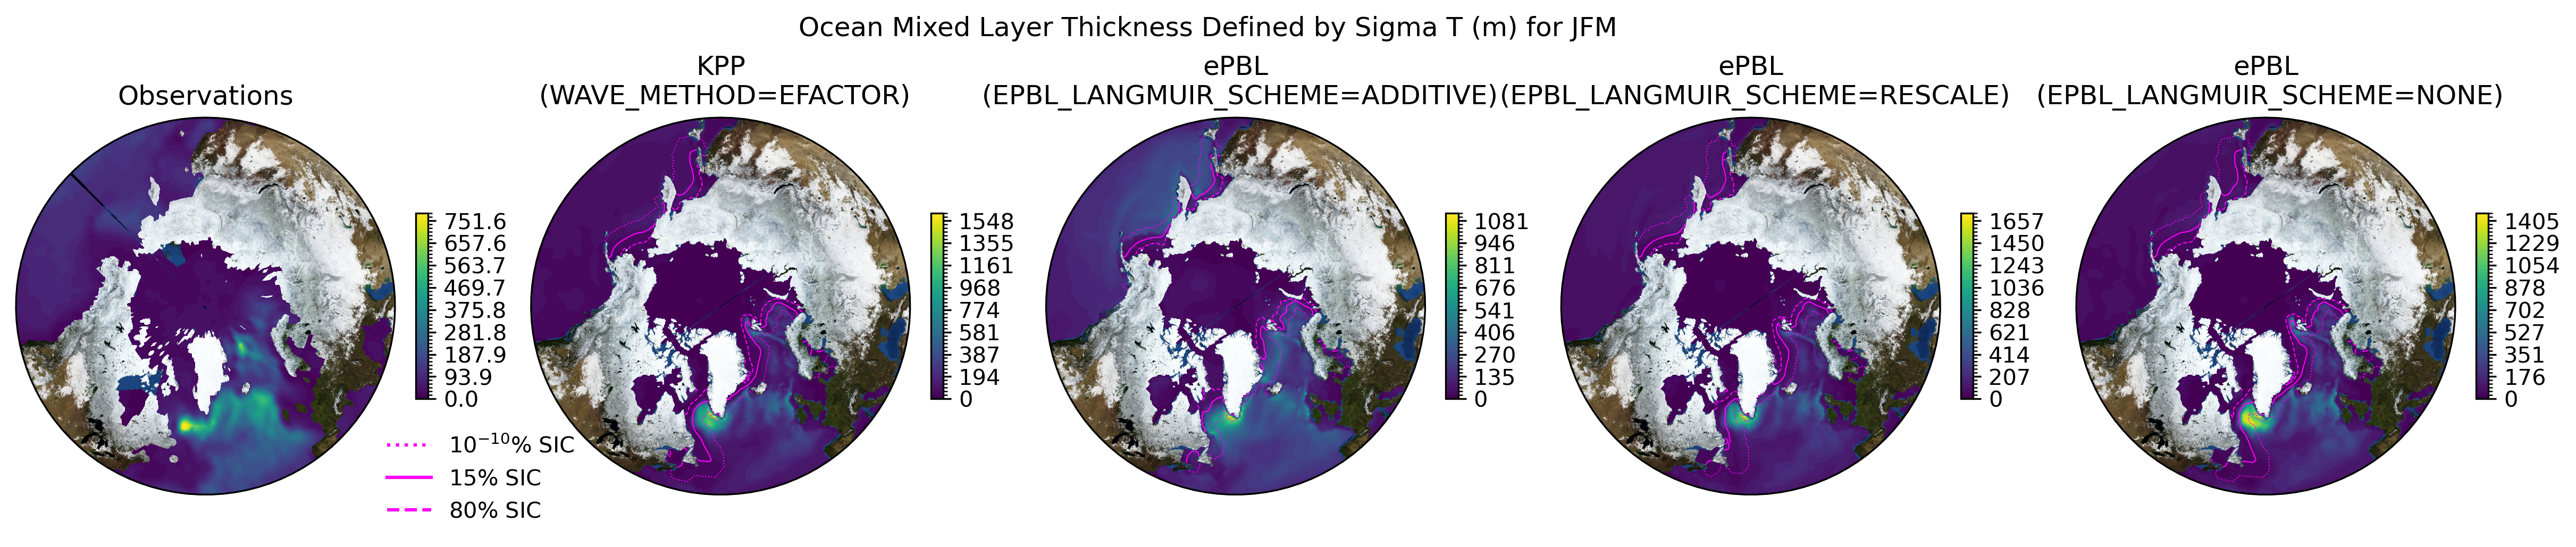

In [15]:
hemisphere = "north"
vmax = None
number_panels = len(experiments) + 1
fig, axes = make_fig(number_panels=number_panels, hemisphere=hemisphere)

plot(MLDobs_JFM_mean,
    levels=51,
    vmin=0,
    vmax=vmax,
    # extend="max",
    cmap='viridis',
    ax=axes[0],
    title="Observations",
    hemisphere=hemisphere
    )

expts = list(experiments.keys())
plot_label_dict = {
    expts[0]: 'KPP\n (WAVE_METHOD=EFACTOR)',
    expts[1]: 'ePBL\n (EPBL_LANGMUIR_SCHEME=ADDITIVE)',
    expts[2]: 'ePBL\n (EPBL_LANGMUIR_SCHEME=RESCALE)',
    expts[3]: 'ePBL\n (EPBL_LANGMUIR_SCHEME=NONE)',
}

plot_label_dict_short = {
    expts[0]: 'KPP\n (eFactor)',
    expts[1]: 'ePBL\n (Additive)',
    expts[2]: 'ePBL\n (Rescale)',
    expts[3]: 'ePBL\n (None)',
}

for i, ax in enumerate(axes[1:]):
    plot(mld_seasons[expts[i]]['JFM']['mlotst'],
        dat_ice=aice_seasons[expts[i]]['JFM'],
        levels=51,
        vmin=0,
        vmax=vmax,
        # extend="max",
        cmap='viridis',
        ax=ax,
        title=plot_label_dict[expts[i]],
        hemisphere=hemisphere
        )

# Add legend
line_puny = mlines.Line2D([], [], color="magenta", linestyle=':', label="$10^{-10}\%$ SIC")
line_15 = mlines.Line2D([], [], color="magenta", linestyle='-', label="$15\%$ SIC")
line_80 = mlines.Line2D([], [], color="magenta", linestyle='--', label="$80\%$ SIC")

fig.legend(
    handles=[line_puny, line_15, line_80],
    loc='lower left',
    bbox_to_anchor=(0.235, 0.125),
    frameon=False
)

fig.suptitle(
    f"{mld_seasons[expts[0]]['JFM']['mlotst'].attrs['long_name']} ({mld_seasons[expts[0]]['JFM']['mlotst'].attrs['units']}) for JFM ",
    y=0.95
)

plt.savefig(plotfolder+"LT_MLD_maps_arctic_JFM.png") 

### Plot the MLD for the Southern Ocean

kpp
epbl (additive)
epbl (rescale)
epbl (none)


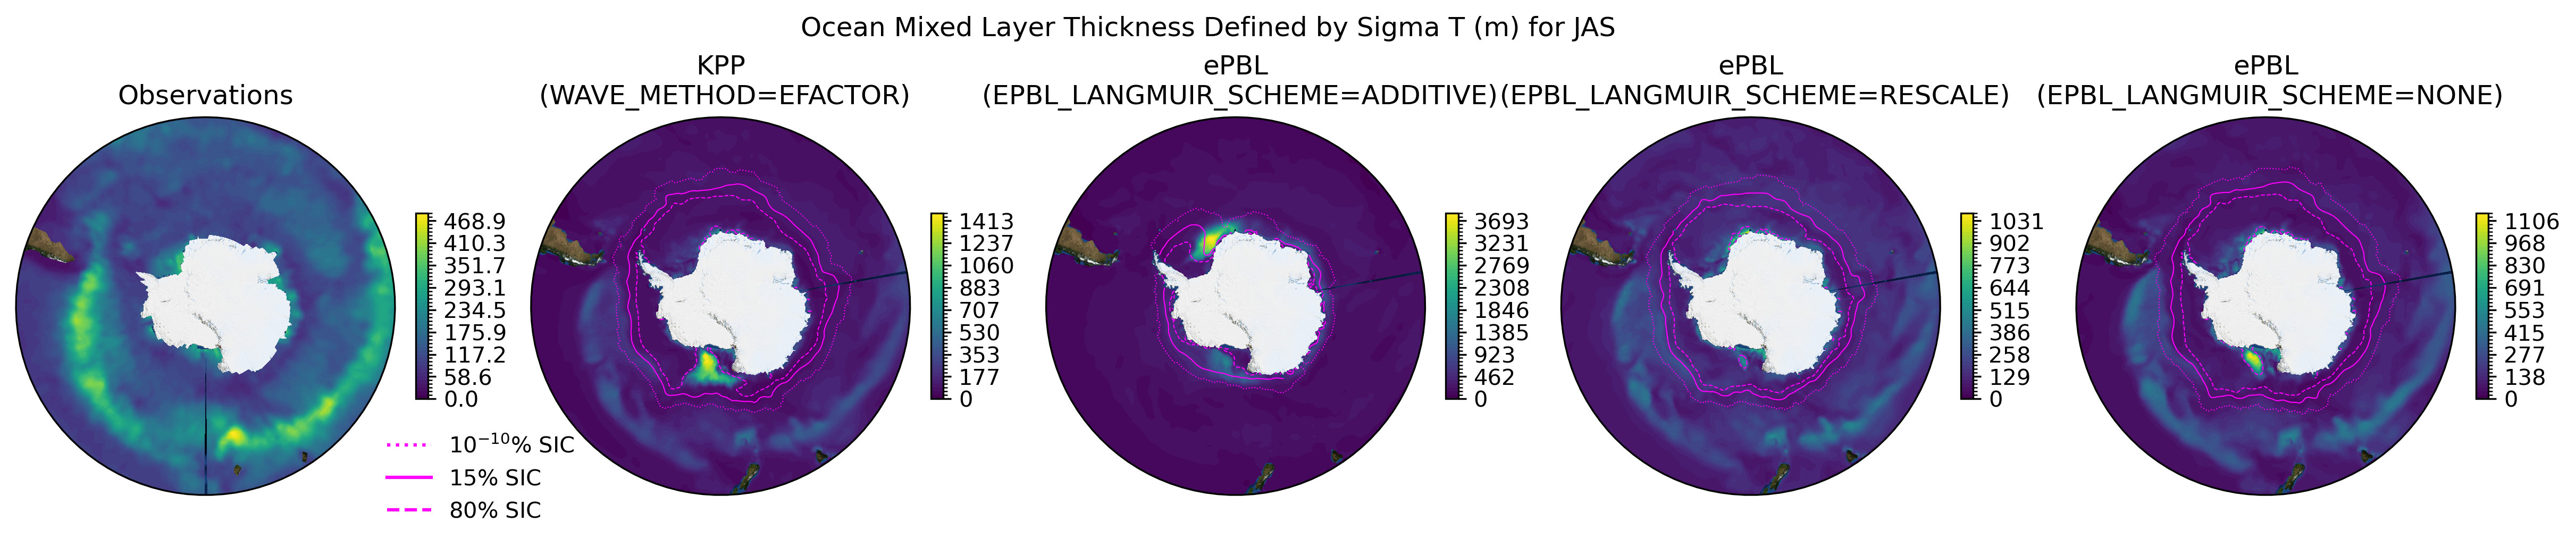

In [16]:
hemisphere = "south"
vmax = None

fig, axes = make_fig(number_panels=number_panels, hemisphere=hemisphere)

plot(MLDobs_JAS_mean,
    levels=51,
    vmin=0,
    vmax=vmax,
    # extend="max",
    cmap='viridis',
    ax=axes[0],
    title="Observations",
    hemisphere=hemisphere
    )

for i, ax in enumerate(axes[1:]):
    print(expts[i])
    if not mld_seasons[expts[i]]['JAS']['mlotst'].isnull().all().values:
        plot(mld_seasons[expts[i]]['JAS']['mlotst'],
            dat_ice=aice_seasons[expts[i]]['JAS'],
            levels=51,
            vmin=0,
            vmax=vmax,
            # extend="max",
            cmap='viridis',
            ax=ax,
            title=plot_label_dict[expts[i]],
            hemisphere=hemisphere
            )

# Add legend
line_puny = mlines.Line2D([], [], color="magenta", linestyle=':', label="$10^{-10}\%$ SIC")
line_15 = mlines.Line2D([], [], color="magenta", linestyle='-', label="$15\%$ SIC")
line_80 = mlines.Line2D([], [], color="magenta", linestyle='--', label="$80\%$ SIC")

fig.legend(
    handles=[line_puny, line_15, line_80],
    loc='lower left',
    bbox_to_anchor=(0.235, 0.125),
    frameon=False
)
fig.suptitle(
    f"{mld_seasons[expts[0]]['JAS']['mlotst'].attrs['long_name']} ({mld_seasons[expts[0]]['JAS']['mlotst'].attrs['units']}) for JAS ",
    y=0.95
)
plt.savefig(plotfolder+"LT_MLD_maps_antarctic_JAS.png") 

## Compare time series

### MLD timeseries

In [17]:
def plot_timeseries(data, var, aice, legend_labels, ylabel, climatology=False):
    fig = plt.figure(figsize=(8, 4))
    gs = gridspec.GridSpec(nrows=2, ncols=2, width_ratios=[5, 1], wspace=0.05)
    
    axes = [fig.add_subplot(gs[i, 0]) for i in range(2)]
    legend_ax = fig.add_subplot(gs[:, 1])  # Span both rows
    legend_ax.axis('off') 

    for i, hemisphere in enumerate(["north", "south"]):
        expt0 = list(aice.keys())[0]  # Just used to get grid
        if hemisphere=="south":
            lat_slice = slice(0, int(len(aice[expt0].yh)/2))
        else:  # north
            lat_slice = slice(int(len(aice[expt0].yh)/2), None)
            
        area_slice = aice[expt0]['areacello'].isel(yh=lat_slice)
        
        for exp in data.keys():
            if var == "sia": # Calculate sea ice area
                data_slice = data[exp]['aice_m'].isel(yh=lat_slice)
                data_ts = (data_slice * area_slice).where(data_slice > 0.15).sum(dim=['yh', 'xh']) * 1e-12
            elif var == "sie": # Calculate sea ice extent
                if climatology:
                    data_slice = data[exp]['aice_m'].isel(yh=lat_slice).groupby('time.month').mean('time')
                else:
                    data_slice = data[exp]['aice_m'].isel(yh=lat_slice)
                data_ts = area_slice.where(data_slice > 0.15).sum(dim=['yh', 'xh']) * 1e-12
            else:
                data_slice = data[exp][var].isel(yh=lat_slice)
                data_ts = (data_slice * area_slice).sum(dim=['yh', 'xh']) / area_slice.sum(dim=['yh', 'xh'])
            data_ts.plot(ax=axes[i], label=plot_label_dict_short[exp])
    
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
    axes[0].set_xticklabels('')

    for ax, label, hemisphere in zip(axes, string.ascii_lowercase, ["north", "south"]):
        ax.text(
            0.02, 0.98,
            f'{label}) {legend_labels[hemisphere]}',
            transform=ax.transAxes,
            fontweight='bold',
            va='top',
            ha='left'
        )

    # Put legend in the separate axis
    handles, labels = axes[0].get_legend_handles_labels()
    legend_ax.legend(handles, labels, loc='center', frameon=False)
    legend_ax.axis('off')
    
    fig.text(
        0.05, 0.5,
        ylabel, 
        va='center', ha='center', rotation='vertical', fontsize=12
    )
    return fig, axes, legend_ax

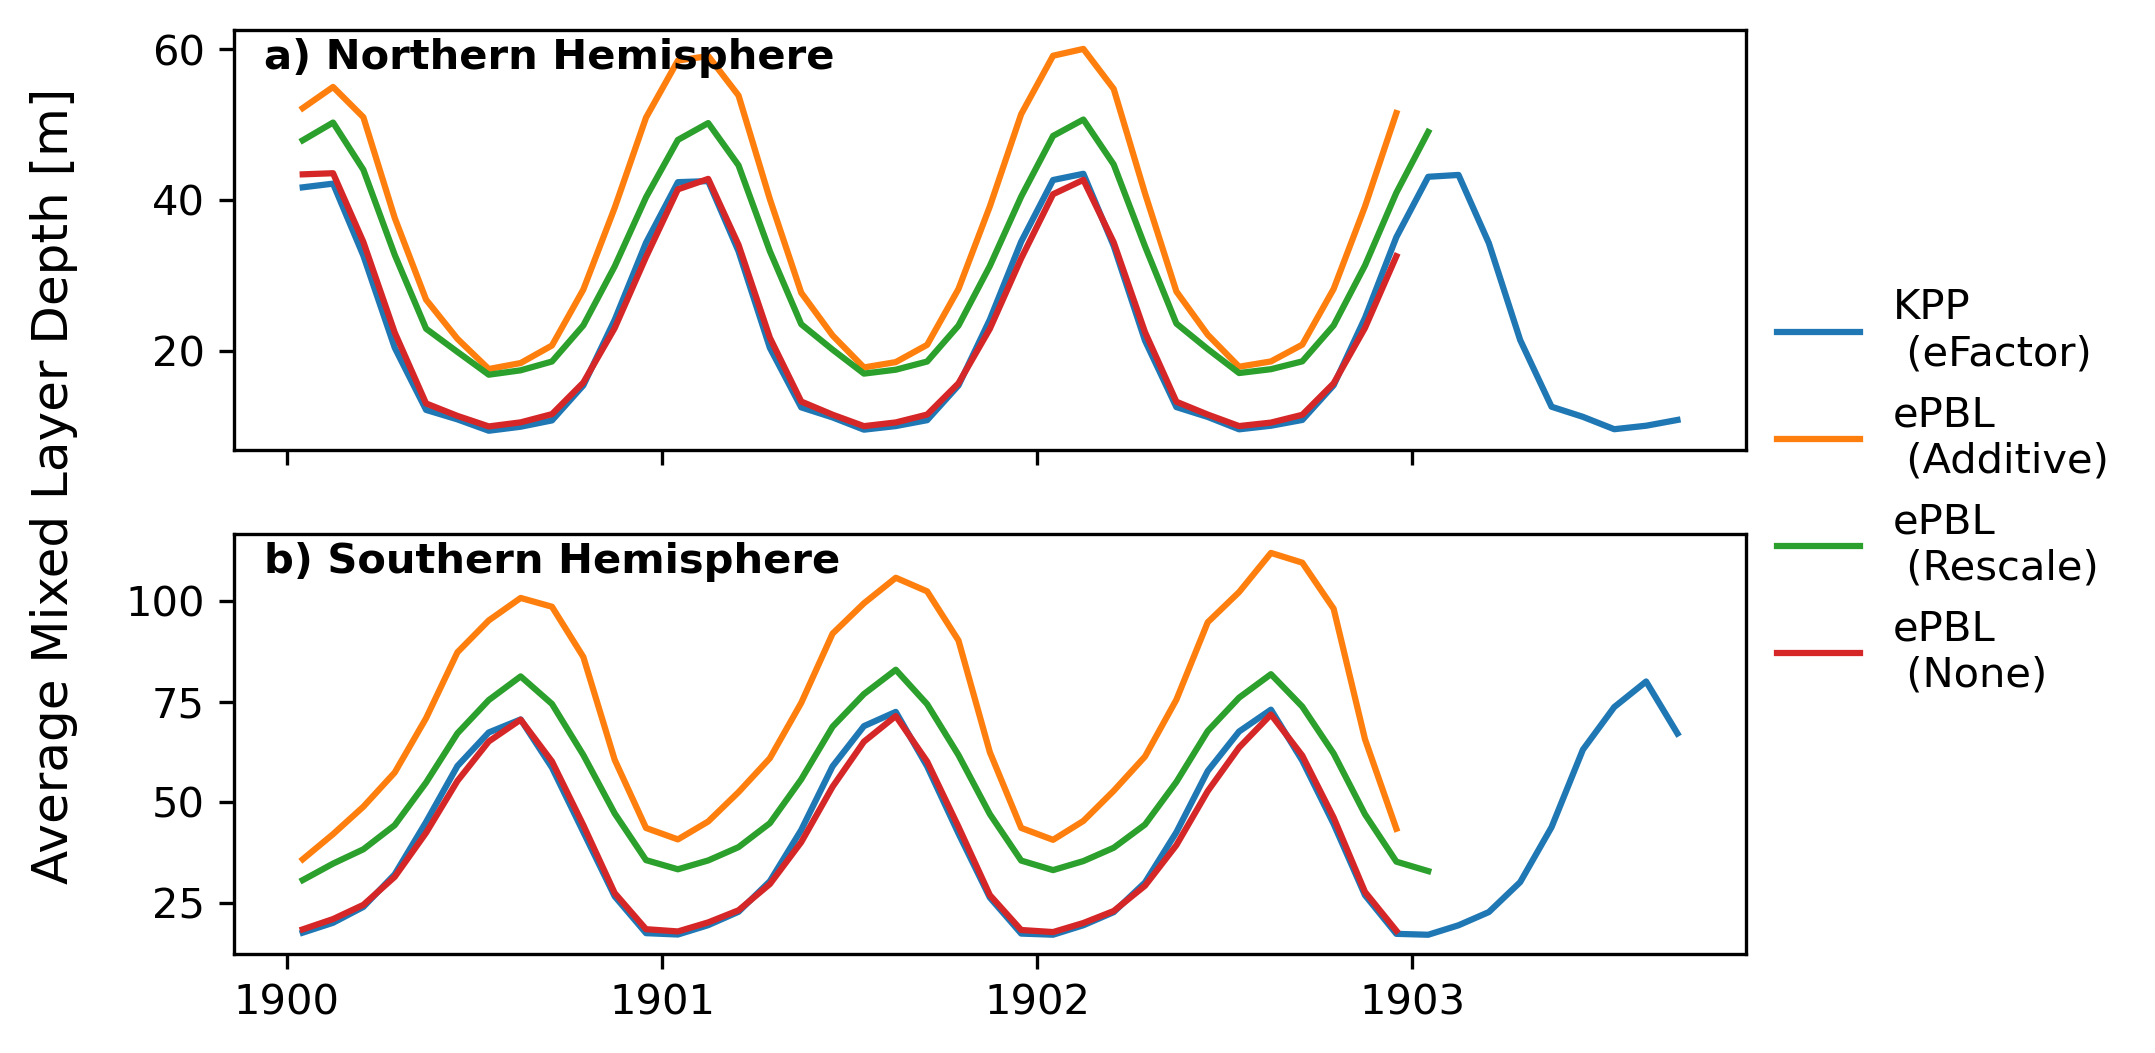

In [18]:
hemisphere_label_dict = {
    "north": "Northern Hemisphere",
    "south": "Southern Hemisphere",
}
ylabel='Average Mixed Layer Depth [m]'
fig, axes, legend_ax = plot_timeseries(data=mld, var='mlotst', aice=aice, legend_labels=hemisphere_label_dict, ylabel=ylabel)

plt.savefig(plotfolder+"LT_MLD_timeseries.png")

### Sea ice area and extent
First we plot the timeseries of sea ice area for each pole.

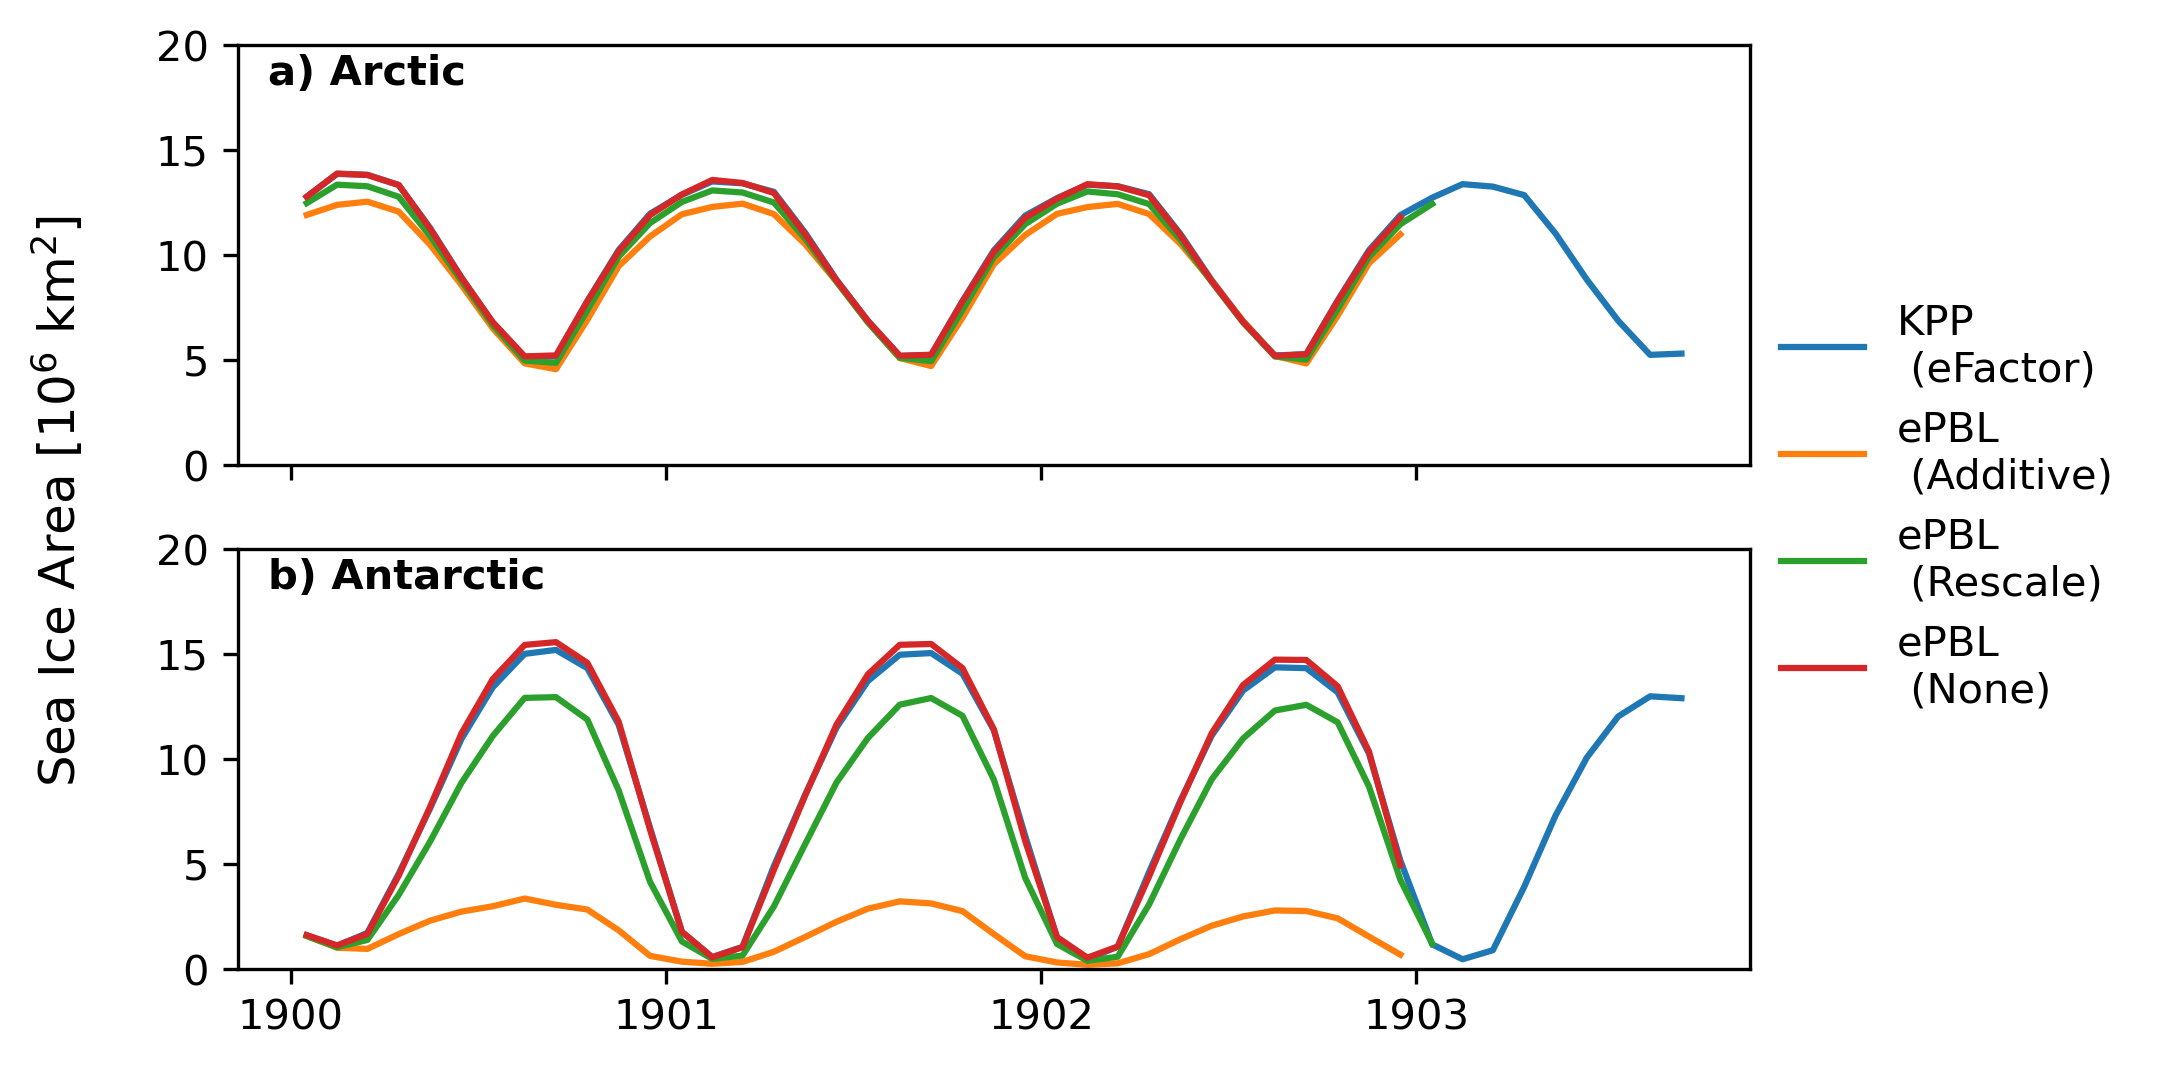

In [19]:
hemisphere_label_dict = {
    "north": "Arctic",
    "south": "Antarctic",
}
ylabel='Sea Ice Area [$10^6$ km$^2$]'
fig, axes, legend_ax = plot_timeseries(data=aice, var='sia', aice=aice, legend_labels=hemisphere_label_dict, ylabel=ylabel)
for ax in axes:
    ax.set_ylim(0, 20)
plt.savefig(plotfolder+"LT_sia_timeseries.png")

Now let's plot the sea ice extents too.

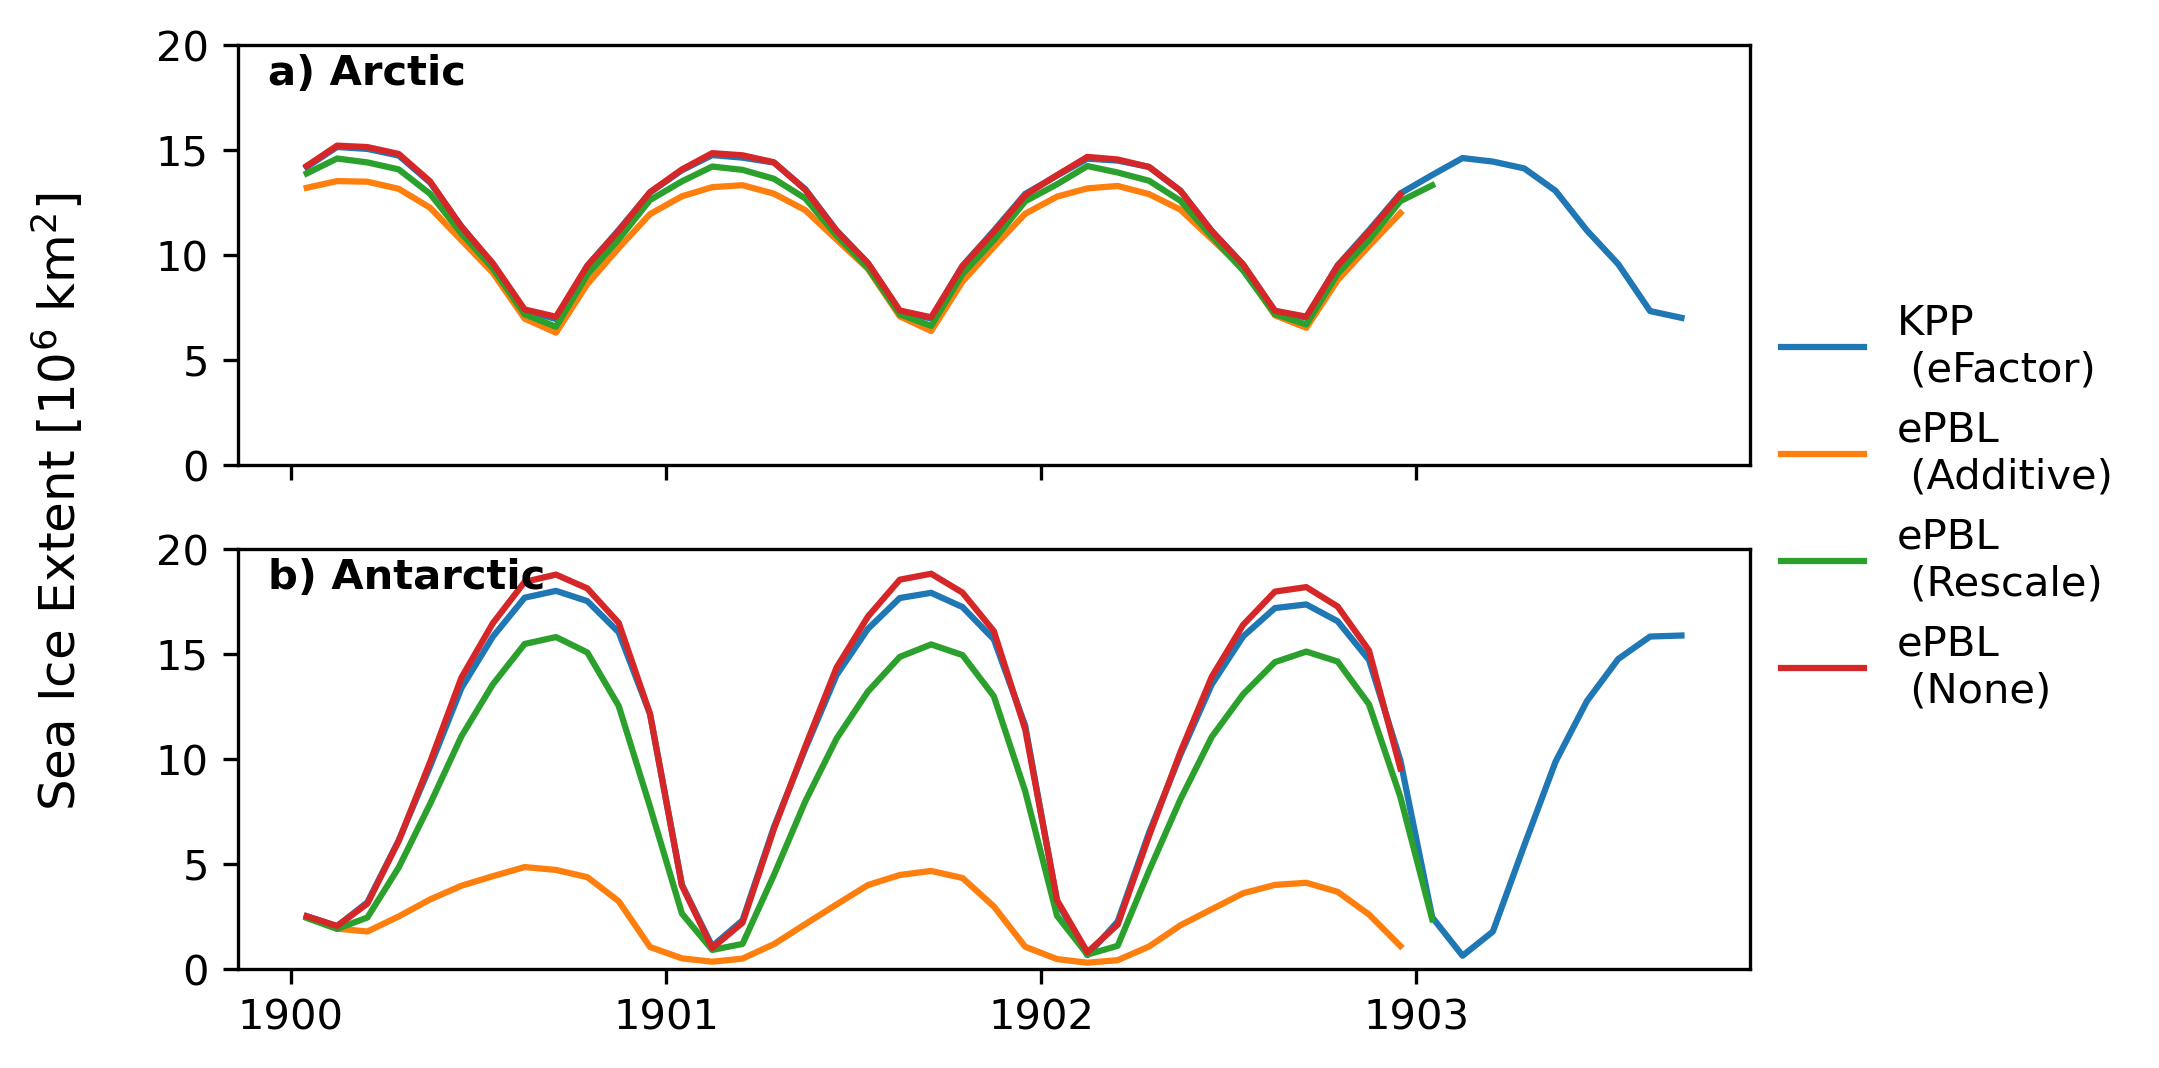

In [20]:
hemisphere_label_dict = {
    "north": "Arctic",
    "south": "Antarctic",
}
ylabel='Sea Ice Extent [$10^6$ km$^2$]'
fig, axes, legend_ax = plot_timeseries(data=aice, var='sie', aice=aice, legend_labels=hemisphere_label_dict, ylabel=ylabel)
for ax in axes:
    ax.set_ylim(0, 20)
plt.savefig(plotfolder+"LT_sie_timeseries.png")

### Compare sea ice extents against observations for 1990

In [21]:
nh_obs = xr.open_mfdataset('/g/data/av17/access-nri/OM3/CDR_G02202_V5/NSIDC-G02202-nh/sic_psn25_1990*.nc')

In [22]:
sh_obs = xr.open_mfdataset('/g/data/av17/access-nri/OM3/CDR_G02202_V5/NSIDC-G02202-sh/sic_pss25_1990*.nc')
sh_obs

<xarray.Dataset> Size: 11MB
Dimensions:                          (time: 12, y: 332, x: 316)
Coordinates:
  * time                             (time) datetime64[ns] 96B 1990-01-01 ......
  * x                                (x) float64 3kB -3.938e+06 ... 3.938e+06
  * y                                (y) float64 3kB 4.338e+06 ... -3.938e+06
Data variables:
    cdr_seaice_conc_monthly          (time, y, x) float32 5MB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    cdr_seaice_conc_monthly_stdev    (time, y, x) float32 5MB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    cdr_seaice_conc_monthly_qa_flag  (time, y, x) uint8 1MB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    crs                              (time) int32 48B -2147483647 ... -214748...
Attributes: (12/46)
    Conventions:               CF-1.11, ACDD-1.3
    date_created:              2024-11-20T21:31:45Z
    time_coverage_start:       1990-01-01T00:00:00Z
    time_coverage_end:         1990-01-31T23:59:59Z
    time_coverage_resolution:  P1M
    time_coverage_duration:    P1M
    ...                        ...
    geospatial_lat_min:        -90.0
    geospatial_lat_max:        -39.23089
    geospatial_lon_min:        -180.0
    geospatial_lon_max:        180.0
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east

In [23]:
areasNd = np.fromfile("psn25area_v3.dat", dtype=np.int32).reshape(
    nh_obs.cdr_seaice_conc_monthly.isel(time=0).shape
)
areasKmNd_nh = areasNd /1000 #convert to km^2
    
nh_obs["area"] = xr.DataArray(areasKmNd_nh, dims=["y", "x"])
nh_obs = nh_obs.set_coords("area")

In [24]:
areasNd = np.fromfile("pss25area_v3.dat", dtype=np.int32).reshape(
    sh_obs.cdr_seaice_conc_monthly.isel(time=0).shape
)
areasKmNd_sh = areasNd /1000 #convert to km^2
    
sh_obs["area"] = xr.DataArray(areasKmNd_sh, dims=["y", "x"])
sh_obs = sh_obs.set_coords("area")

In [25]:
sh_sic = sh_obs['cdr_seaice_conc_monthly']
sharea = sh_obs.area.load()

nh_sic = nh_obs['cdr_seaice_conc_monthly']
nharea = nh_obs.area.load()

antarctic_seaice_obs = (sh_sic * sharea).sum(['y','x'])
arctic_seaice_obs = (nh_sic * nharea).sum(['y','x'])

sh_area_obs = antarctic_seaice_obs.compute()
nh_area_obs = arctic_seaice_obs.compute()

sh_extent_obs = sharea.where(sh_sic > 0.15).sum(['y','x']).compute()
nh_extent_obs = nharea.where(nh_sic > 0.15).sum(['y','x']).compute()

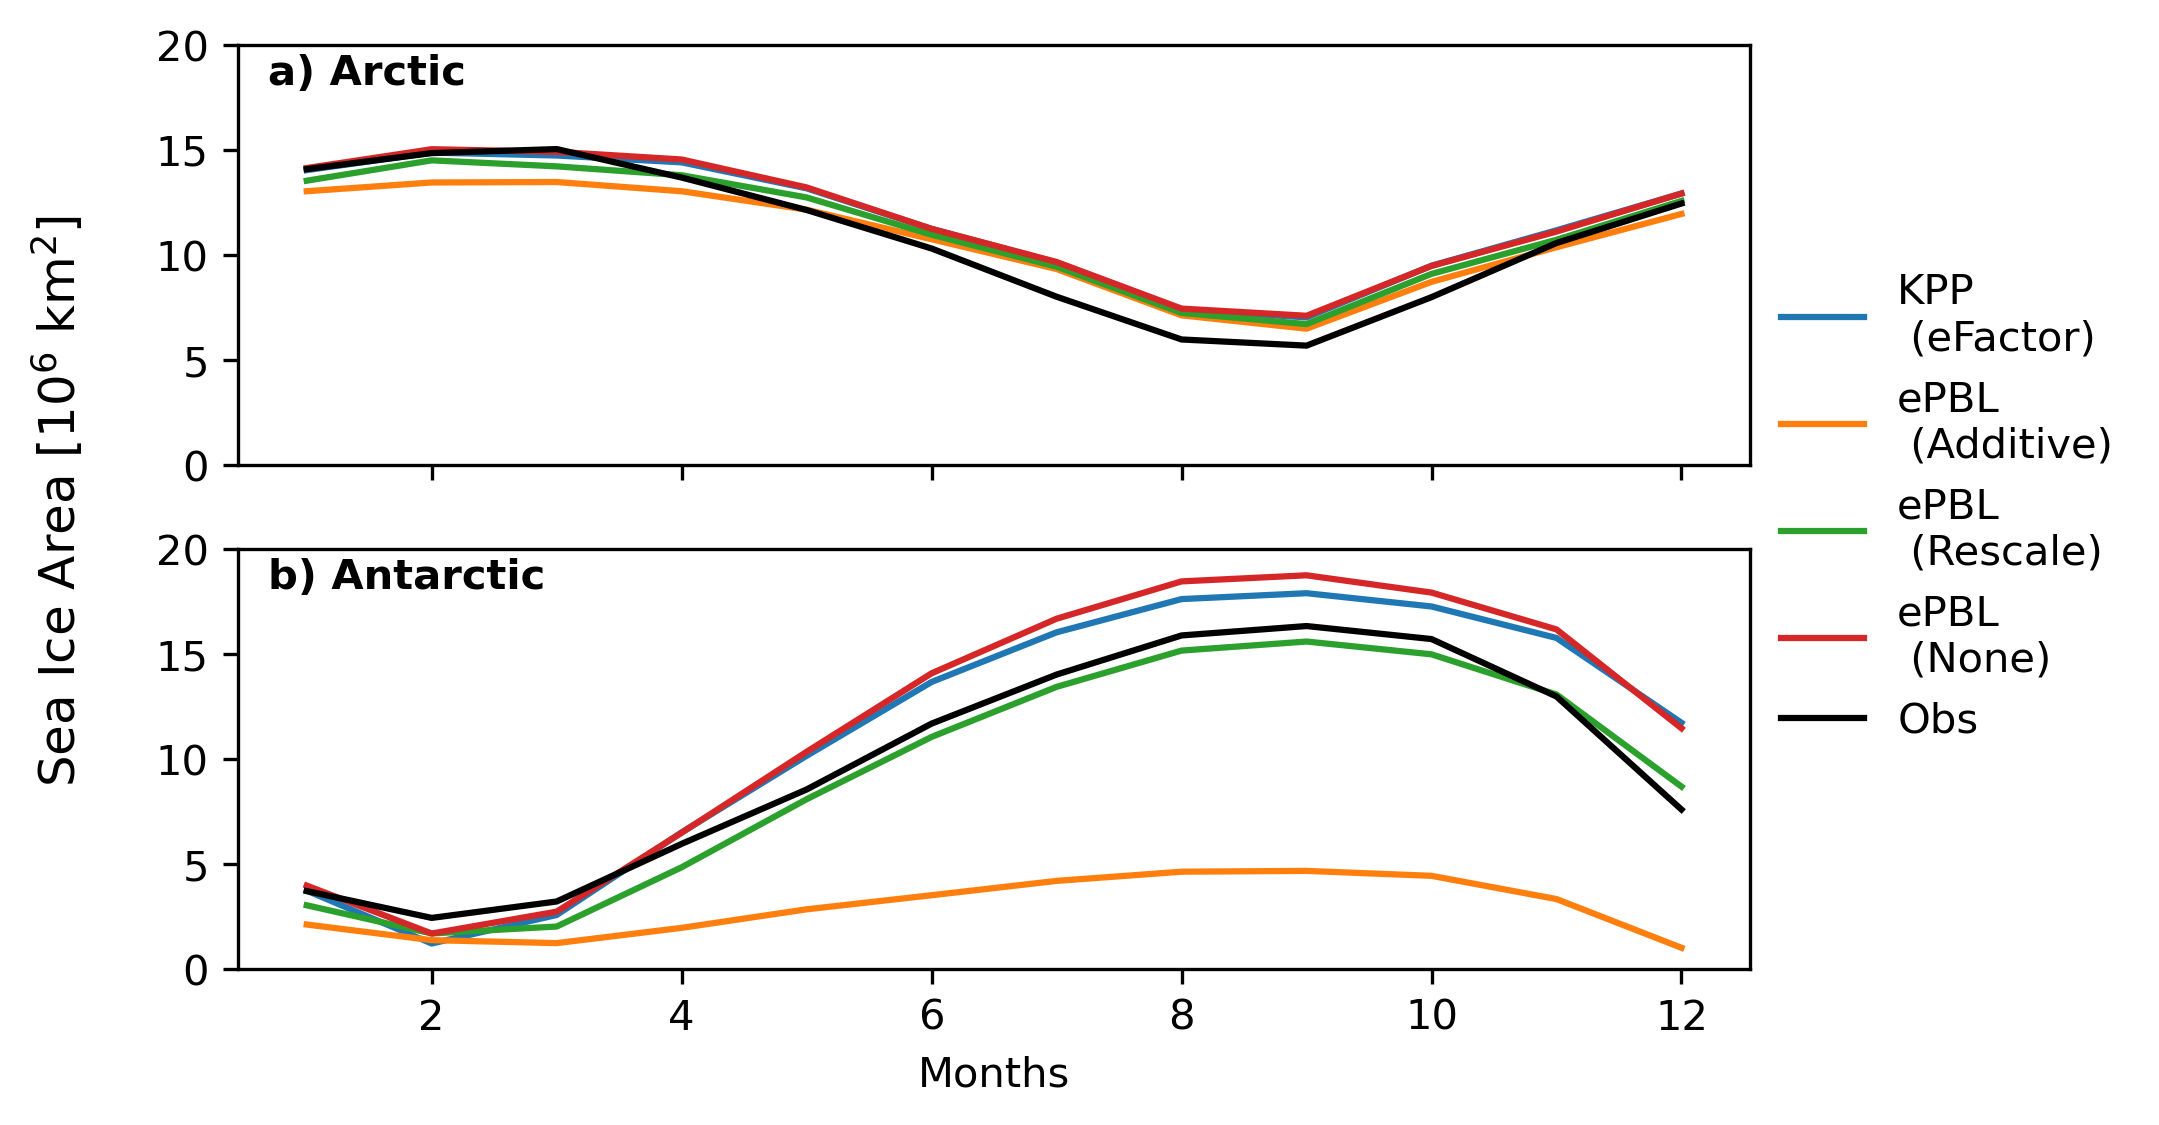

In [26]:
hemisphere_label_dict = {
    "north": "Arctic",
    "south": "Antarctic",
}
ylabel='Sea Ice Area [$10^6$ km$^2$]'
fig, axes, legend_ax = plot_timeseries(data=aice, var='sie', aice=aice, legend_labels=hemisphere_label_dict, ylabel=ylabel, climatology=True)

x = np.arange(1, 13)
axes[0].plot(x, nh_area_obs * 1e-6,
             color='k',
             label='Obs',
)

axes[1].plot(x, sh_area_obs * 1e-6,
            color='k',
)

axes[1].set_xlabel('Months')

handles, labels = axes[0].get_legend_handles_labels()
legend_ax.legend(handles, labels, loc='center', frameon=False)
for ax in axes:
    ax.set_ylim(0, 20)
plt.savefig(plotfolder+"LT_sia_climatology.png")

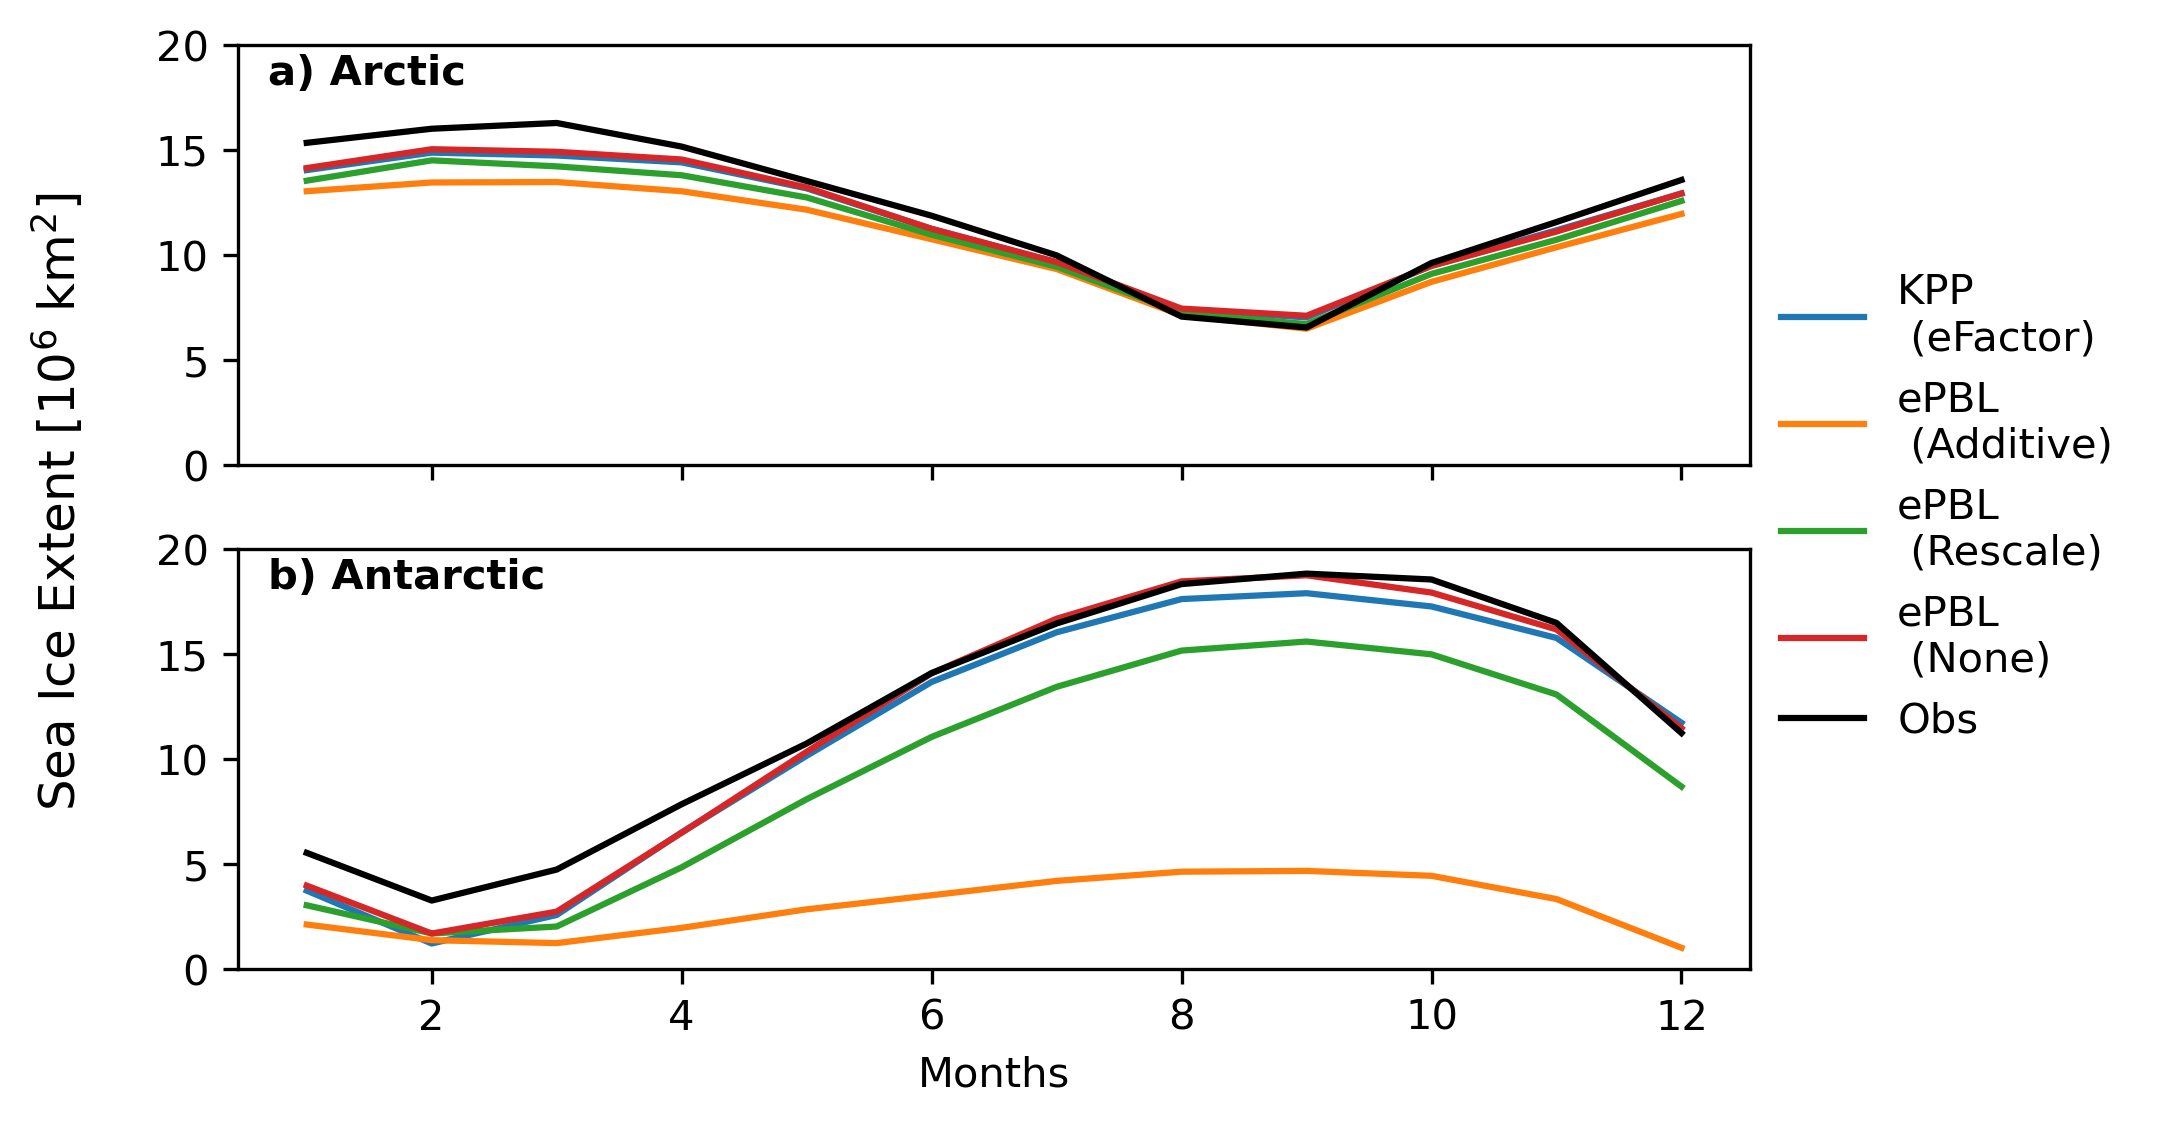

In [27]:
hemisphere_label_dict = {
    "north": "Arctic",
    "south": "Antarctic",
}
ylabel='Sea Ice Extent [$10^6$ km$^2$]'
fig, axes, legend_ax = plot_timeseries(data=aice, var='sie', aice=aice, legend_labels=hemisphere_label_dict, ylabel=ylabel, climatology=True)

x = np.arange(1, 13)
axes[0].plot(x, nh_extent_obs * 1e-6,
             color='k',
             label='Obs',
)

axes[1].plot(x, sh_extent_obs * 1e-6,
            color='k',
)

axes[1].set_xlabel('Months')

handles, labels = axes[0].get_legend_handles_labels()
legend_ax.legend(handles, labels, loc='center', frameon=False)

for ax in axes:
    ax.set_ylim(0, 20)
plt.savefig(plotfolder+"LT_sie_climatology.png")

## SIC anomalies

Calculate in the same way as [COSIMA Recipes](https://github.com/COSIMA/cosima-recipes/blob/main/03-Mains/Sea_Ice_Area_Concentration_Volume_with_Obs.ipynb).

In [28]:
! wget -nc https://noaadata.apps.nsidc.org/NOAA/G02202_V5/ancillary/G02202-ancillary-pss25-v05r00.nc

File ‘G02202-ancillary-pss25-v05r00.nc’ already there; not retrieving.



In [29]:
cdr_sps_ds = xr.open_dataset("G02202-ancillary-pss25-v05r00.nc")

Make regridder and test regridding

In [30]:
# Make aice CF complient
regridder = xesmf.Regridder(
    aice[expts[0]].isel(time=0).drop_vars(["lon", "lat"]).rename({'xh':'longitude', 'yh':'latitude'}), 
    cdr_sps_ds,
    method="bilinear",
    periodic=True,
    unmapped_to_nan=True,
)

In [31]:
aice_regridded = xr.Dataset()
aice_sh_anom_ds = xr.Dataset()

# Test if it works
month_idx = 9
for expt in list(experiments.keys()):
    aice_regridded[expt] = regridder(
        aice[expt].groupby('time.month').mean('time').aice_m.copy()
    )
    aice_sh_anom_ds[expt] = aice_regridded[expt].isel(month=month_idx) - sh_obs["cdr_seaice_conc_monthly"].isel(time=month_idx-1)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('yh', 'xh') from data variable aice_m as the horizontal dimensions for the regridding.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/xarray/computation/apply_ufunc.py:305: PerformanceWarning: Regridding is increasing the number of chunks by a factor of 6.0, you might want to specify sizes in `output_chunks` in the regridder call. Default behaviour is to preserve the chunk sizes from the input (150, 180).
  result_var = func(*data_vars)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('yh', 'xh') from data variable aice_m as the horizontal dimensions for the regridding.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/xarray/computation/apply_ufunc.py:305

Plot maps of the sea ice concentration anomalies

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('yh', 'xh') from data variable aice_m as the horizontal dimensions for the regridding.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('yh', 'xh') from data variable aice_m as the horizontal dimensions for the regridding.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('yh', 'xh') from data variable aice_m as the horizontal dimensions for the regridding.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('yh', 'xh') from data variable aice_m as the horizontal dimensions for the regridding.
  warnings.warn(
/g/data/xp65/public/apps/med

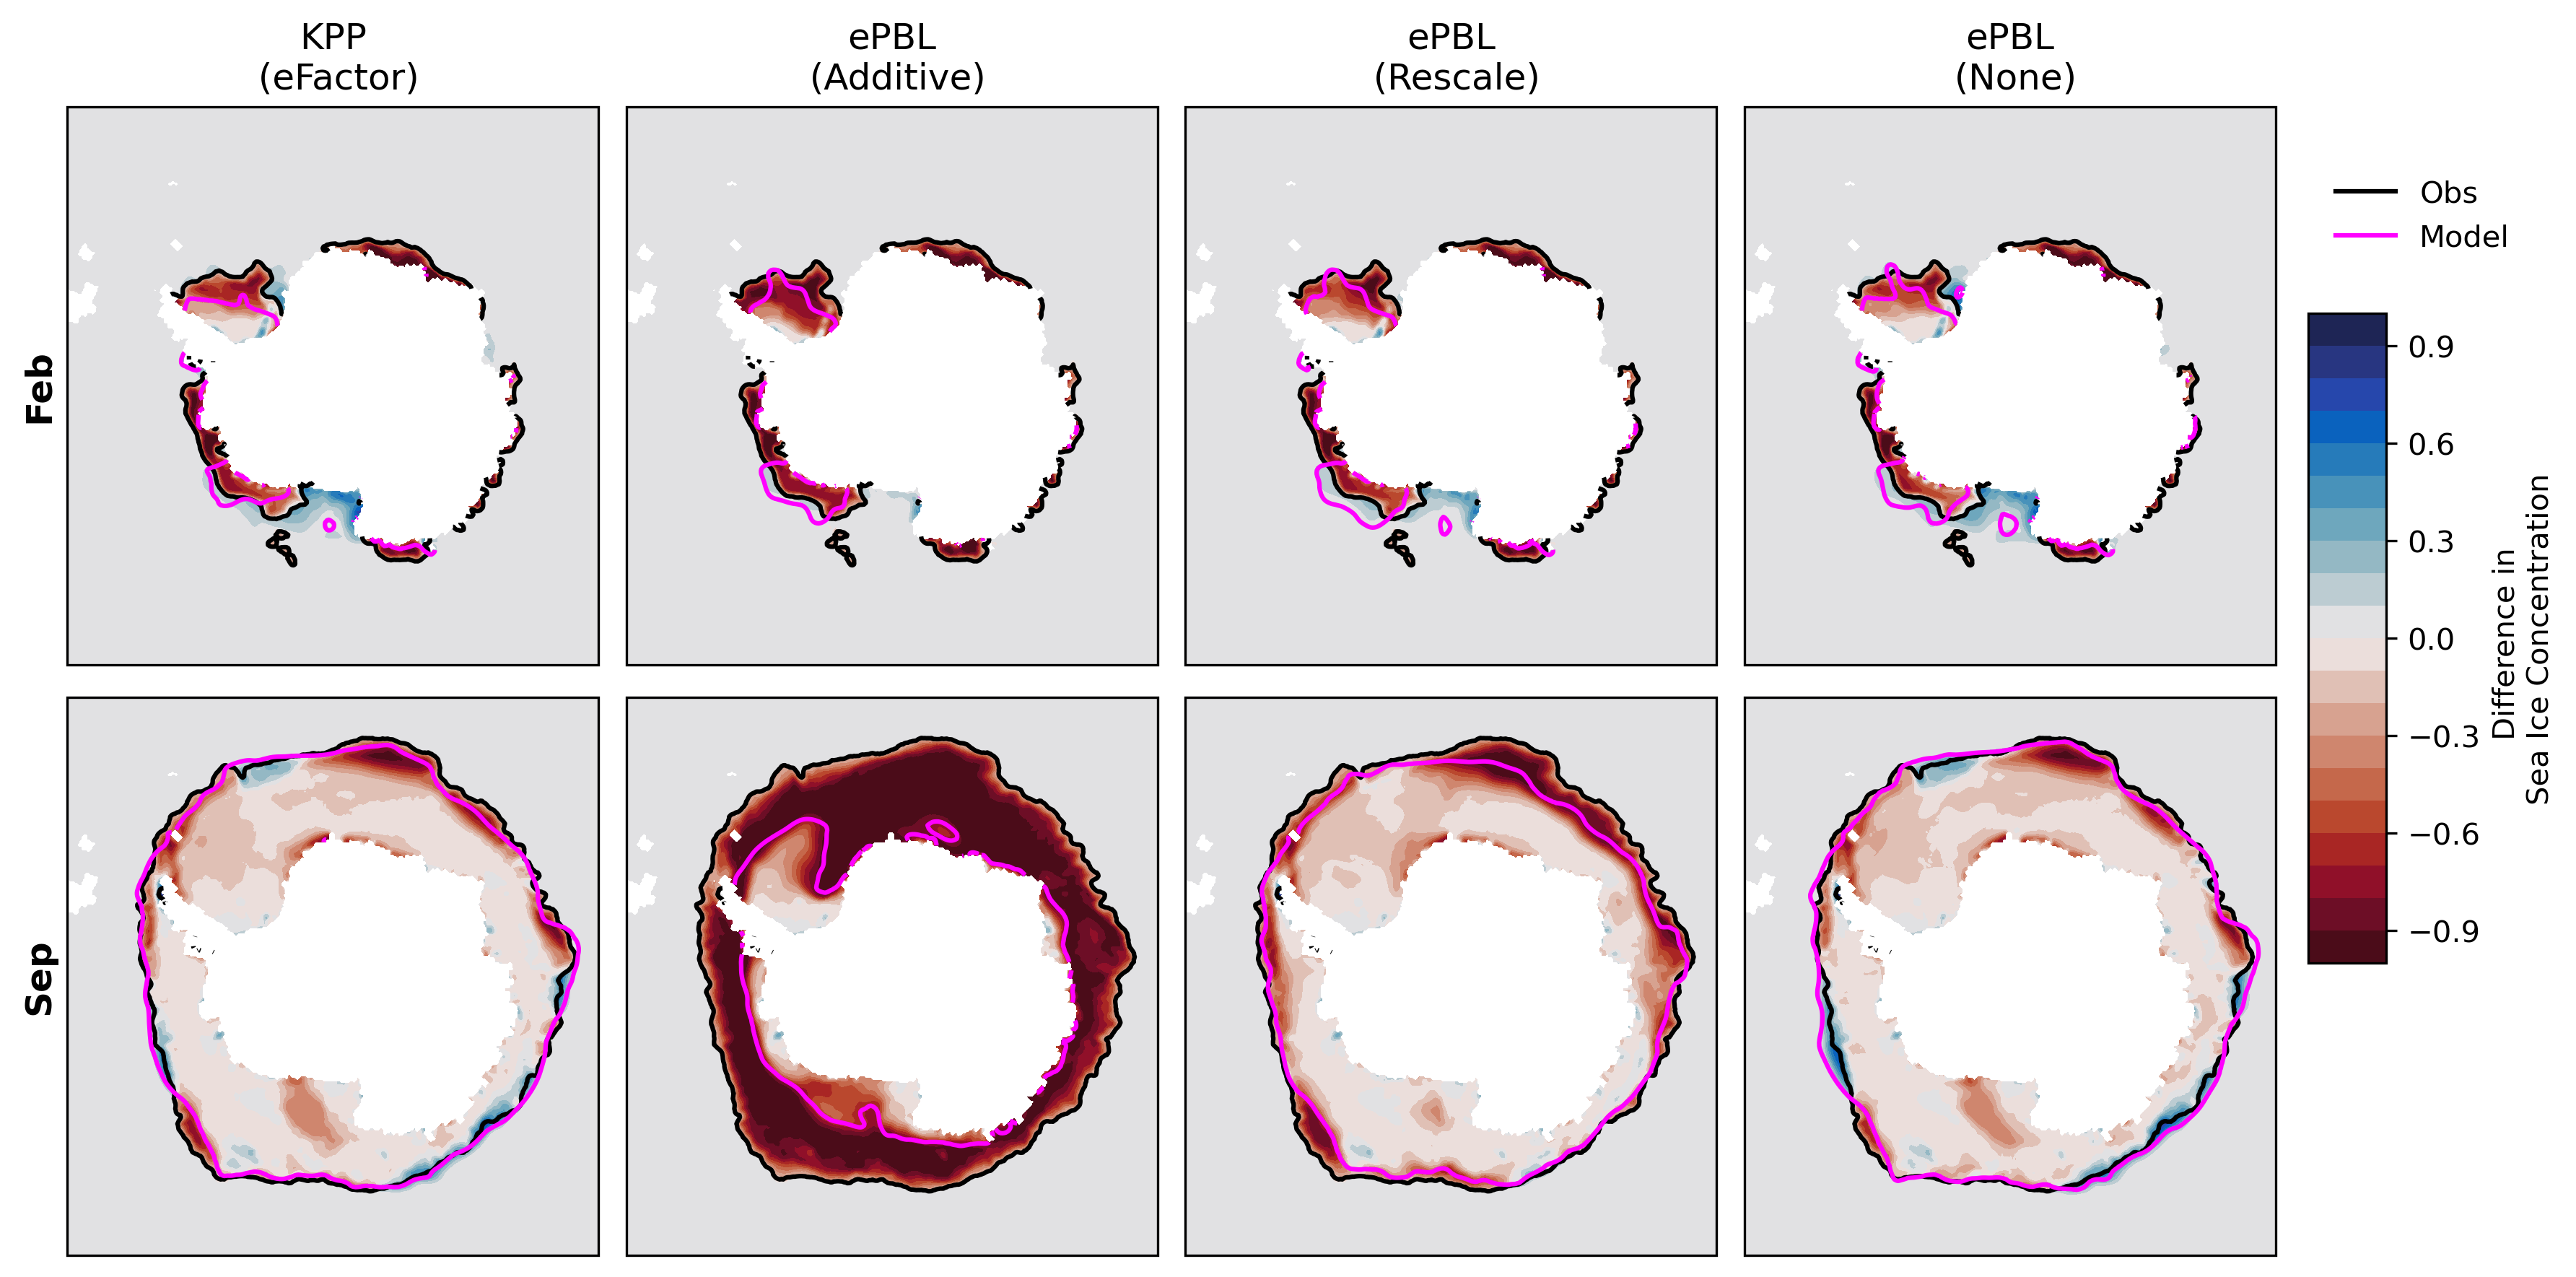

In [32]:
months = [2, 9]  # Feb, Sep
month_names = ["Feb", "Sep"]
n_months = len(months)
experiments_list = list(experiments.keys())
n_expts = len(experiments_list)

fig, axes = plt.subplots(
    nrows=n_months, ncols=n_expts,
    figsize=(3*n_expts, 3*n_months),
    subplot_kw={'projection': ccrs.SouthPolarStereo(true_scale_latitude=-70)}
)

# If axes is 1D for single month or single experiment, make it 2D
axes = np.atleast_2d(axes)

for i, iMonth in enumerate(months):
    for j, expt in enumerate(experiments_list):
        ax = axes[i, j]
        
        # Regrid and compute anomaly
        aice_regridded[expt] = regridder(
            aice[expt].groupby('time.month').mean('time').aice_m.copy().load()
        )
        aice_sh_anom_ds[expt] = aice_regridded[expt].isel(month=iMonth) - sh_obs["cdr_seaice_conc_monthly"].isel(time=iMonth-1)
        
        # Plot anomaly
        im = ax.contourf(
            aice_sh_anom_ds.x, aice_sh_anom_ds.y, aice_sh_anom_ds[expt],
            levels=np.arange(-1.0 , 1.1, 0.1), cmap=cmo.balance_r
        )
        
        # Ice edge lines
        sh_obs["cdr_seaice_conc_monthly"].isel(time=iMonth-1).plot.contour(
            ax=ax, levels=[0.15], colors="black"
        )
        aice_regridded[expt].sel(month=iMonth).plot.contour(
            ax=ax, levels=[0.15], colors="magenta"
        )
        
        if i == 0:
            ax.set_title(plot_label_dict_short[expt])
        else:
            ax.set_title('')

# Add legend
line_cdr = mlines.Line2D([], [], color="black", label="Obs")
line_mod = mlines.Line2D([], [], color="magenta", label="Model")
fig.legend(
    handles=[line_cdr, line_mod],
    loc='center left',
    bbox_to_anchor=(0.9, 0.825),
    frameon=False
)

# Add colour bar
cbar_ax = fig.add_axes([0.90, 0.25, 0.03, 0.5])
fig.colorbar(im, cax=cbar_ax, label="Difference in \nSea Ice Concentration")

fig.tight_layout(rect=[0.025, 0, 0.9, 1]) 

# After plotting everything, add month labels on the left
for i, month_name in enumerate(month_names):
    ax = axes[i, 0]
    y = ax.get_position().y0 + ax.get_position().height/2  # center of row
    fig.text(0.02, y, month_name,
        va='center', ha='left', fontsize=12, fontweight='bold', rotation=90,
    )

plt.savefig(plotfolder+"LT_sic_anomalies_maps_antarctic.png")
plt.show()

## SST Comparison

### SST Observations

In [33]:
obs_sst = xr.open_mfdataset('/g/data/ik11/inputs/access-om3/woa23/1deg/2025.10.24/woa23_ts_*', 
                            chunks={'time': -1}).isel(depth=0).rename({'lat': 'yh', 'lon': 'xh'}).load()
geolon = datastore_epbl.search(variable="geolon", file_id='access_om3_mom6_static').to_dask().geolon
geolat = datastore_epbl.search(variable="geolat", file_id='access_om3_mom6_static').to_dask().geolat
obs_sst = obs_sst.assign_coords({ "lon": geolon, "lat": geolat })
obs_sst

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/source.py:308: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/source.py:308: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(


<xarray.Dataset> Size: 43MB
Dimensions:             (time: 12, nbounds: 2, yh: 300, xh: 360)
Coordinates:
  * xh                  (xh) float64 3kB -279.5 -278.5 -277.5 ... 77.5 78.5 79.5
  * yh                  (yh) float64 2kB -77.88 -77.63 -77.38 ... 89.32 89.77
    depth               float64 8B 0.5413
  * time                (time) datetime64[ns] 96B 1955-01-16T12:00:00 ... 195...
    lon                 (yh, xh) float64 864kB dask.array<chunksize=(300, 360), meta=np.ndarray>
    lat                 (yh, xh) float64 864kB dask.array<chunksize=(300, 360), meta=np.ndarray>
Dimensions without coordinates: nbounds
Data variables:
    climatology_bounds  (time, nbounds) float64 192B 0.0 2.456e+04 ... 2.484e+04
    ptemp               (time, yh, xh) float64 10MB 1.598 1.598 ... 0.1931
    temp                (time, yh, xh) float64 10MB 1.605 1.605 ... 0.2352
    salt                (time, yh, xh) float64 10MB 33.53 33.53 ... 7.848 7.848
    asalt               (time, yh, xh) float64 10MB 33.69 33.69 ... 7.885 7.886
Attributes:
    Conventions:       CF-1.10
    title:             ACCESS-OM3 ocean initial conditions
    input_file:        /g/data/ik11/inputs/access-om3/woa23/monthly/2025.10.2...
    ocean_hgrid_file:  /g/data/vk83/configurations/inputs/access-om3/mom/grid...
    ocean_vgrid_file:  /g/data/vk83/prerelease/configurations/inputs/access-o...
    history:           Generated from WOA23 t & s, regridded onto MOM6 vertic...

In [34]:
def get_sst_bias(model, obs, name, coords=None, seasons=None):
    """
    Compute SST bias between a model SST field and observed SST field,
    using the same seasonal logic defined in seasonal_ds().

    Returns a dict with the same keys as seasonal_ds().
    """

    # Compute seasonal climatologies using your existing function
    model_seasons = seasonal_ds(model, seasons)
    obs_seasons   = seasonal_ds(obs,   seasons)

    out = {}

    # Compute bias for each entry returned by seasonal_ds
    for key in model_seasons.keys():
        bias = (model_seasons[key] - obs_seasons[key]).load()

        if coords is not None:
            # Allow Dataset or dict
            if hasattr(coords, "coords"):
                coords_dict = {k: v for k, v in coords.coords.items()}
            else:
                coords_dict = coords[name]

            bias = bias.assign_coords(coords_dict)

        out[key] = bias

    return out

sst_bias = {
    name: get_sst_bias(ds['tos'], obs_sst['temp'], name, coords=coords)
    for name, ds in sst.items()
}
sst_bias.keys()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 10.14 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 10.09 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/cli

dict_keys(['kpp', 'epbl (additive)', 'epbl (rescale)', 'epbl (none)'])

## SST comparison with WOA23

### Arctic comparison Jan–Mar

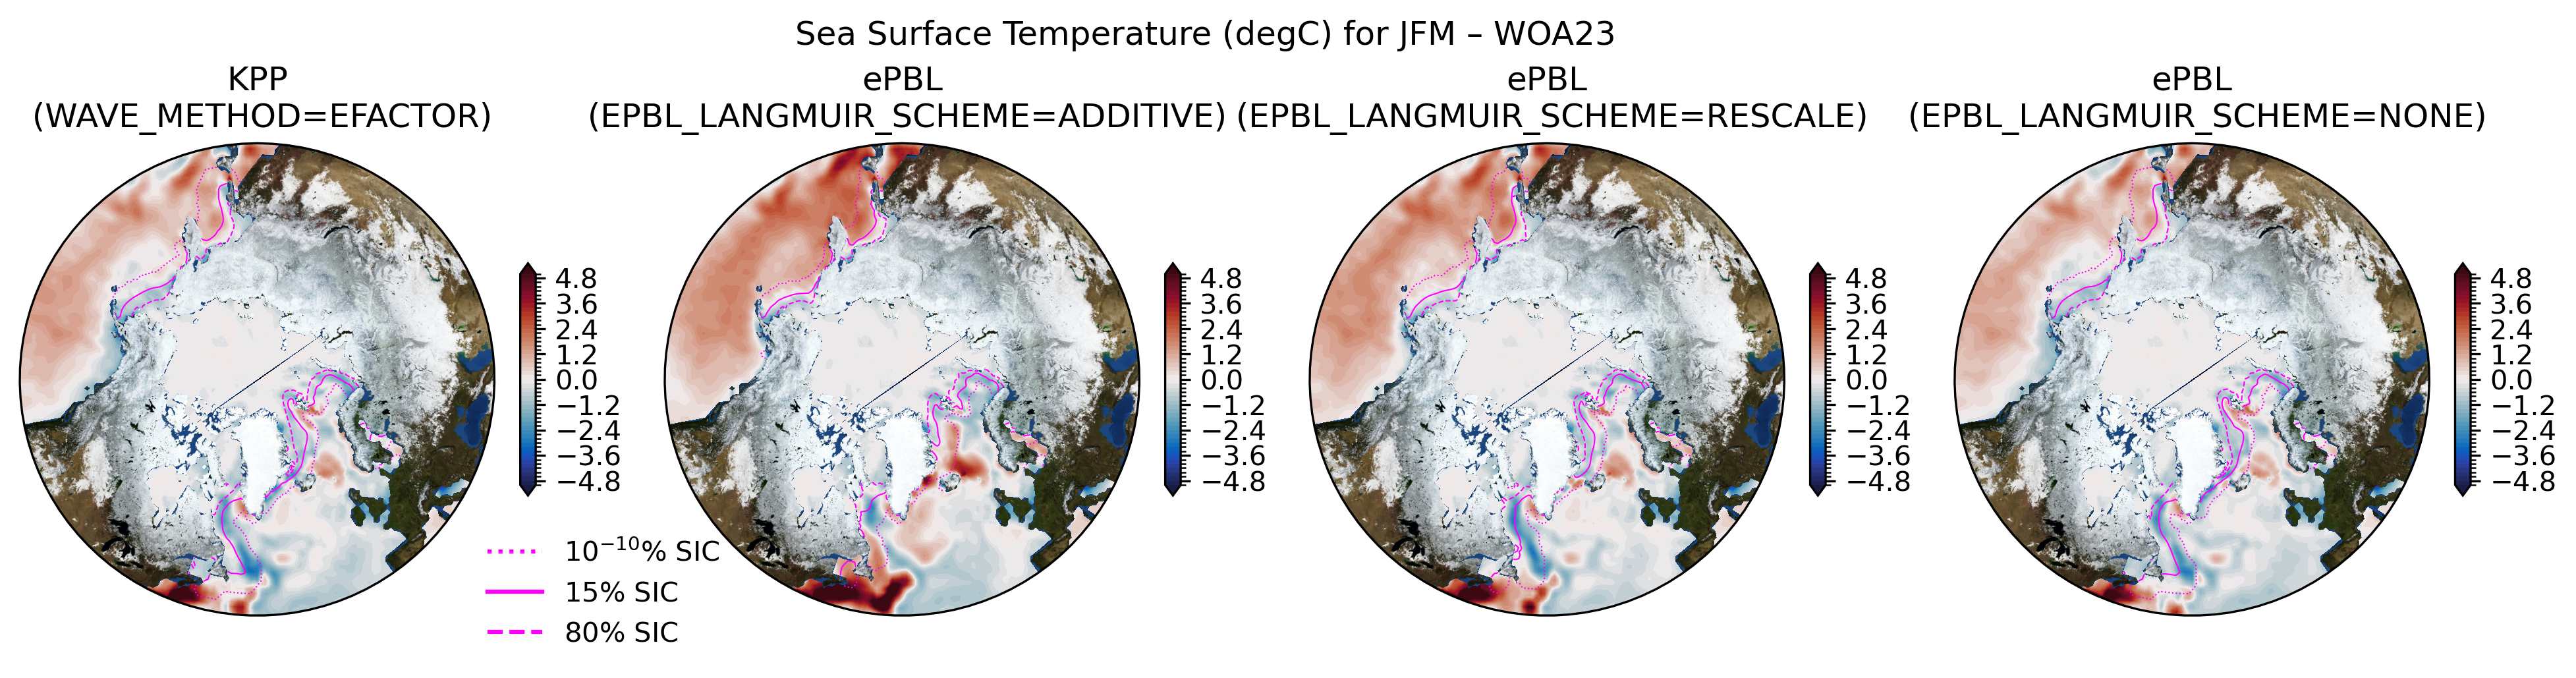

In [35]:
hemisphere = "north"
vmin, vmax = -5, 5
number_panels = len(experiments)
fig, axes = make_fig(number_panels=number_panels, hemisphere=hemisphere)

for i, ax in enumerate(axes):
    plot(sst_bias[expts[i]]['JFM'],
        dat_ice=aice_seasons[expts[i]]['JFM'],
        levels=51,
        vmin=vmin,
        vmax=vmax,
        # extend="max",
        cmap=cmo.balance,
        ax=ax,
        title=plot_label_dict[expts[i]],
        hemisphere=hemisphere
        )
    
# Add legend
line_puny = mlines.Line2D([], [], color="magenta", linestyle=':', label="$10^{-10}\%$ SIC")
line_15 = mlines.Line2D([], [], color="magenta", linestyle='-', label="$15\%$ SIC")
line_80 = mlines.Line2D([], [], color="magenta", linestyle='--', label="$80\%$ SIC")

fig.legend(
    handles=[line_puny, line_15, line_80],
    loc='lower left',
    bbox_to_anchor=(0.265, 0.125),
    frameon=False
)

fig.suptitle(
    f"{sst[expts[0]]['tos'].attrs['long_name']} ({sst[expts[0]]['tos'].attrs['units']}) for JFM – WOA23", 
    y=0.95
)
plt.savefig(plotfolder+"LT_SST_bias_maps_arctic_JFM.png") 

### Antarctic comparison Jul–Sep

In [ ]:
hemisphere = "south"
vmin, vmax = -5, 5

fig, axes = make_fig(number_panels=number_panels, hemisphere=hemisphere)

for i, ax in enumerate(axes):
    plot(sst_bias[expts[i]]['JAS'],
        dat_ice=aice_seasons[expts[i]]['JAS'],
        levels=51,
        vmin=vmin,
        vmax=vmax,
        # extend="max",
        cmap=cmo.balance,
        ax=ax,
        title=plot_label_dict[expts[i]],
        hemisphere=hemisphere
        )

# Add legend
line_puny = mlines.Line2D([], [], color="magenta", linestyle=':', label="$10^{-10}\%$ SIC")
line_15 = mlines.Line2D([], [], color="magenta", linestyle='-', label="$15\%$ SIC")
line_80 = mlines.Line2D([], [], color="magenta", linestyle='--', label="$80\%$ SIC")

fig.legend(
    handles=[line_puny, line_15, line_80],
    loc='lower left',
    bbox_to_anchor=(0.265, 0.125),
    frameon=False
)

fig.suptitle(
    f"{sst[expts[0]]['tos'].attrs['long_name']} ({sst[expts[0]]['tos'].attrs['units']}) for JAS – WOA23", 
    y=0.95
)
plt.savefig(plotfolder+"LT_SST_bias_maps_antarctic_JAS.png") 

### Global comparison for Jan–Mar

In [ ]:
hemisphere = "global"
vmin, vmax = -5, 5

fig, axes = make_fig(number_panels=number_panels, hemisphere=hemisphere)

for i, ax in enumerate(axes):
    ax.set_global() 
    plot(sst_bias[expts[i]]['JFM'],
        dat_ice=aice_seasons[expts[i]]['JFM'],
        levels=51,
        vmin=vmin,
        vmax=vmax,
        # extend="max",
        cmap=cmo.balance,
        ax=ax,
        title=plot_label_dict[expts[i]],
        hemisphere=hemisphere
        )


fig.suptitle(
    f"{sst[expts[0]]['tos'].attrs['long_name']} ({sst[expts[0]]['tos'].attrs['units']}) for JFM – WOA23", 
    y=0.95
)
plt.savefig(plotfolder+"LT_SST_bias_maps_global_JFM.png") 

### Global comparison for Jul–Sep

In [ ]:
hemisphere = "global"
vmin, vmax = -5, 5

fig, axes = make_fig(number_panels=number_panels, hemisphere=hemisphere)

for i, ax in enumerate(axes):
    ax.set_global() 
    plot(sst_bias[expts[i]]['JAS'],
        dat_ice=aice_seasons[expts[i]]['JAS'],
        levels=51,
        vmin=vmin,
        vmax=vmax,
        # extend="max",
        cmap=cmo.balance,
        ax=ax,
        title=plot_label_dict[expts[i]],
        hemisphere=hemisphere
        )

fig.suptitle(
    f"{sst[expts[0]]['tos'].attrs['long_name']} ({sst[expts[0]]['tos'].attrs['units']}) for JAS – WOA23", 
    y=0.95
)
plt.savefig(plotfolder+"LT_SST_bias_maps_global_JAS.png") 

In [ ]:
client.close()